# INF-0616 - Projeto 2: Redes neurais

Professora: Esther Colombini -- esther@ic.unicamp.br

Monitor: Jesus Paucar -- j236865@dac.unicamp.br

Este *notebook* faz parte da disciplina INF-0616 no curso de extensão MDC.  

Instituto de Computação - Unicamp 2025

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD

from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

from IPython.display import display

In [2]:
plt.rcParams['figure.figsize'] = (12, 6)

#### Lendo o conjunto de dados

O conjunto de dados consiste em reclamações de clientes a cerca de produtos/serviços oferecidos em uma instituição bancária. ***Garanta que o arquivo*** `customer-issues.csv` ***está no mesmo diretório do notebook***.

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')
# import os
# caminho_pasta = '/content/drive/My Drive/Colab/MDC/AULA4/'

# # Verifique se o caminho da pasta existe
# if os.path.exists(caminho_pasta):
#     # Mude o diretório atual para a pasta desejada
#     os.chdir(caminho_pasta)
#     print("Pasta encontrada. Agora você está na pasta:", caminho_pasta)
# else:
#     print("A pasta especificada não existe:", caminho_pasta)

d = pd.read_csv('customer-issues.csv')
display(d.head())


,date-received,product,sub-product,issue,sub-issue,consumer-message,state,zip-code,tags,via,resolution,timely-response?,disputed?,complaint-id
0,10/1/2016,Credit reporting,NaN,Incorrect information on credit report,Account status,I have outdated information on my credit repor...,AL,352XX,NaN,Web,Closed with explanation,Yes,No,2141773
1,10/17/2016,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,I purchased a new car on XXXX XXXX. The car de...,PA,177XX,Older American,Web,Closed with explanation,Yes,No,2163100
2,6/15/2015,Credit reporting,NaN,Credit reporting company's investigation,Inadequate help over the phone,An account on my credit report has a mistaken ...,VA,224XX,NaN,Web,Closed with explanation,Yes,No,1420702
3,2/3/2016,Debt collection,"Other (i.e. phone, health club, etc.)",Disclosure verification of debt,Not given enough info to verify debt,This company refuses to provide me verificatio...,TX,752XX,NaN,Web,Closed with explanation,Yes,Yes,1772196
4,2/17/2016,Debt collection,Credit card,Improper contact or sharing of info,Talked to a third party about my debt,This complaint is in regards to Square Two Fin...,NE,693XX,NaN,Web,Closed with explanation,Yes,Yes,1790634


##### Exibindo as quatro primeiras mensagens

In [4]:
print(*d.loc[:4, 'consumer-message'], sep='\n\n')

I have outdated information on my credit report that I have previously disputed that has yet to be removed this information is more then seven years old and does not meet credit reporting requirements

I purchased a new car on XXXX XXXX. The car dealer called Citizens Bank to get a 10 day payoff on my loan, good till XXXX XXXX. The dealer sent the check the next day. When I balanced my checkbook on XXXX XXXX. I noticed that Citizens bank had taken the automatic payment out of my checking account at XXXX XXXX XXXX Bank. I called Citizens and they stated that they did not close the loan until XXXX XXXX. ( stating that they did not receive the check until XXXX. XXXX. ). I told them that I did not believe that the check took that long to arrive. XXXX told me a check was issued to me for the amount overpaid, they deducted additional interest. Today ( XXXX XXXX, ) I called Citizens Bank again and talked to a supervisor named XXXX, because on XXXX XXXX. I received a letter that the loan had b

##### Extraíndo um conjunto de testes válido

As mensagens contidas neste conjunto possuem uma relação temporal.
É importante realizar a separação dos sub-conjuntos de treino/teste respeitando esta relação, de forma a garantir que o modelo não seja treinado sobre amostras no futuro e experimentado sobre o passado.

In [5]:
np.random.seed(42)
d.sort_values(by='date-received', inplace=True)

### Modelando a classificação de tópicos baseado nas mensagens de clientes

Observando no gráfico de frequências de produto sobre as conversas que este é um problema extremamente desbalanceado. Há, entretanto, amostras suficientes para a modelagem de um estimador de tópico (de produto) levando em consideração o diálogo do cliente.

In [6]:
def frequencies(dataset, column):
    labels, counts = np.unique(dataset[column], return_counts=True)
    p = np.argsort(counts)[::-1]
    labels, counts = labels[p], counts[p]

    (sns
     .barplot(x=[l[:40] for l in labels], y=counts)
     .set_title(f'Occurrences for The {len(labels)} Classes in {column}'))
    plt.xticks(rotation=90)

    return labels, counts

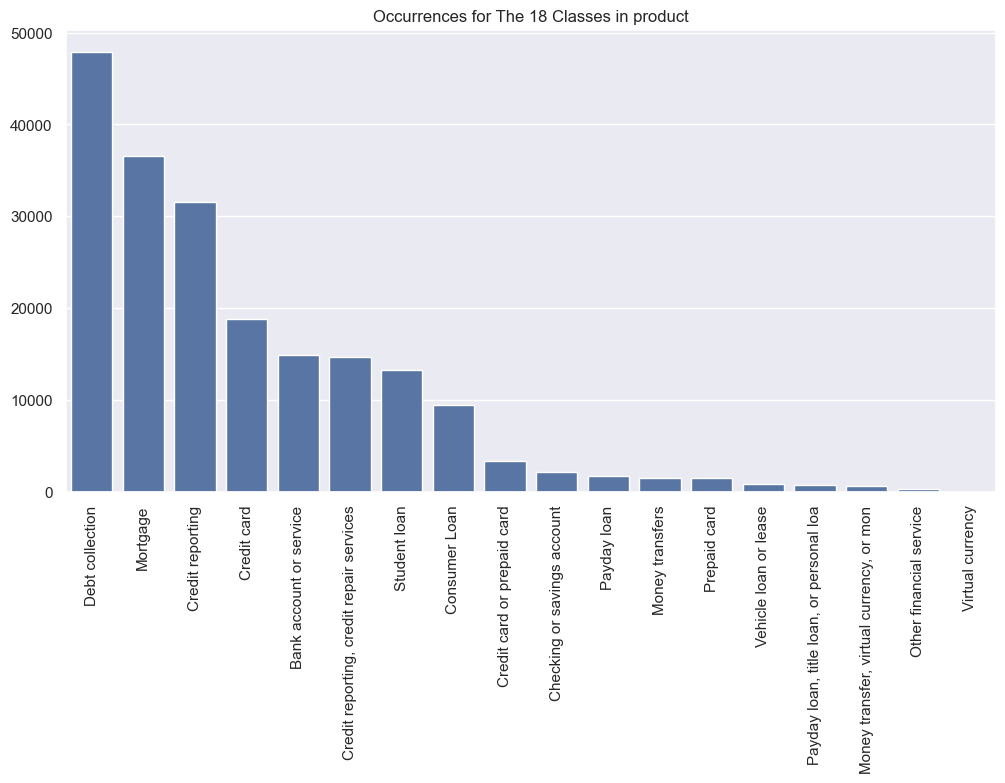

In [7]:
labels, counamts = frequencies(d, 'product')

Simplificamos o problema, considerando somente as 6 classes mais frequentes:

In [8]:
np.random.seed(42)
s = d['product'].isin(labels[:6])
d = d[s]

test_share = .3

d_train, d_test = train_test_split(d, test_size=test_share, shuffle=False)
assert d_train['date-received'].max() <= d_test['date-received'].min()

x_train, x_test = d_train['consumer-message'], d_test['consumer-message']
y_train, y_test = d_train['product'], d_test['product']

Vamos codificar as palavras na conversa utilizando o TF-IDF, gerando um vetor de características baseadas nas frequências de ocorrência das palavras no documento e em todo o conjunto de dados.

In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

features = 1024

encoder = make_pipeline(TfidfVectorizer(min_df=5,
                                        stop_words='english',
                                        strip_accents='unicode',
                                        max_features=features),
                        StandardScaler(with_mean=False))

x_train = encoder.fit_transform(x_train)
x_test = encoder.transform(x_test)

label_enc = LabelEncoder()
ye_train = label_enc.fit_transform(y_train)
ye_test = label_enc.transform(y_test)

## Treinando um regressor logístico para classificar produto
**Atividade (1 pt):** treine um regressor logístico, buscando os hiper-parâmetros com *grid-search*.

In [10]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
np.random.seed(42)

LR = LogisticRegression(
        max_iter=1000,
        random_state=42
    )

grid = {
    "C": [1e-3, 1e-2, 1e-1, 1, 10, 100],
    "class_weight": [None, "balanced"]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

g = GridSearchCV(
    estimator=LR,
    param_grid=grid,
    scoring="balanced_accuracy",
    cv=cv,
    n_jobs=-1,
    refit=True
)
g.fit(x_train, ye_train)


,estimator,LogisticRegre...ndom_state=42)
,param_grid,"{'C': [0.001, 0.01, ...], 'class_weight': [None, 'balanced']}"
,scoring,'balanced_accuracy'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


Iremos calcular a matriz de confusão relativa $R$, que guarda porcentagens de incidências em vez das contagens absolutas, e plotar o heatmap dessa matriz. Além disso, iremos calcular a distribuição de confiança nas predições por classe (mais próximos de `1.0` --> mais confiante):

In [11]:
def evaluate(y, p, probabilities, labels=None):
    # Cálculo das métricas de acerto.
    print(f'Accuracy: {metrics.accuracy_score(y, p):.3f}')
    print(f'Accuracy (balanced): {metrics.balanced_accuracy_score(y, p):.3f}')

    # Calculo da matriz de confusão.
    c = metrics.confusion_matrix(y, p)
    r = c / c.sum(axis=1, keepdims=True)

    # Impressão dos gráficos.
    (plt
     .figure(figsize=(16, 12))
     .suptitle('Matriz de confusão', fontsize=20))
    sns.heatmap(r,
                cmap="YlGnBu", linewidths=.5, annot=True, fmt=".1%",
                xticklabels=labels, yticklabels=labels, cbar=False)

    (plt
     .figure(figsize=(16, 12))
     .suptitle('Distribuição de confiança para cada classe', fontsize=20))

    for i in np.unique(y):
        # Para cada classe `i`, seleciona suas amostras e filtra a confiança
        # do modelo em predizer estas amostras como sendo da classe `i`.
        sns.kdeplot(x = probabilities[y.ravel() == i][:, i],
                    fill = True,
                    label = labels[i] if labels is not None else f'Classe {i}',
                    alpha = 0.4)

    plt.xlabel("Confiança do modelo")
    plt.ylabel("Densidade")
    plt.legend()

Vamos utilizar a função `evaluate` para avaliar o modelo treinado anteriormente:

Accuracy: 0.754
Accuracy (balanced): 0.748


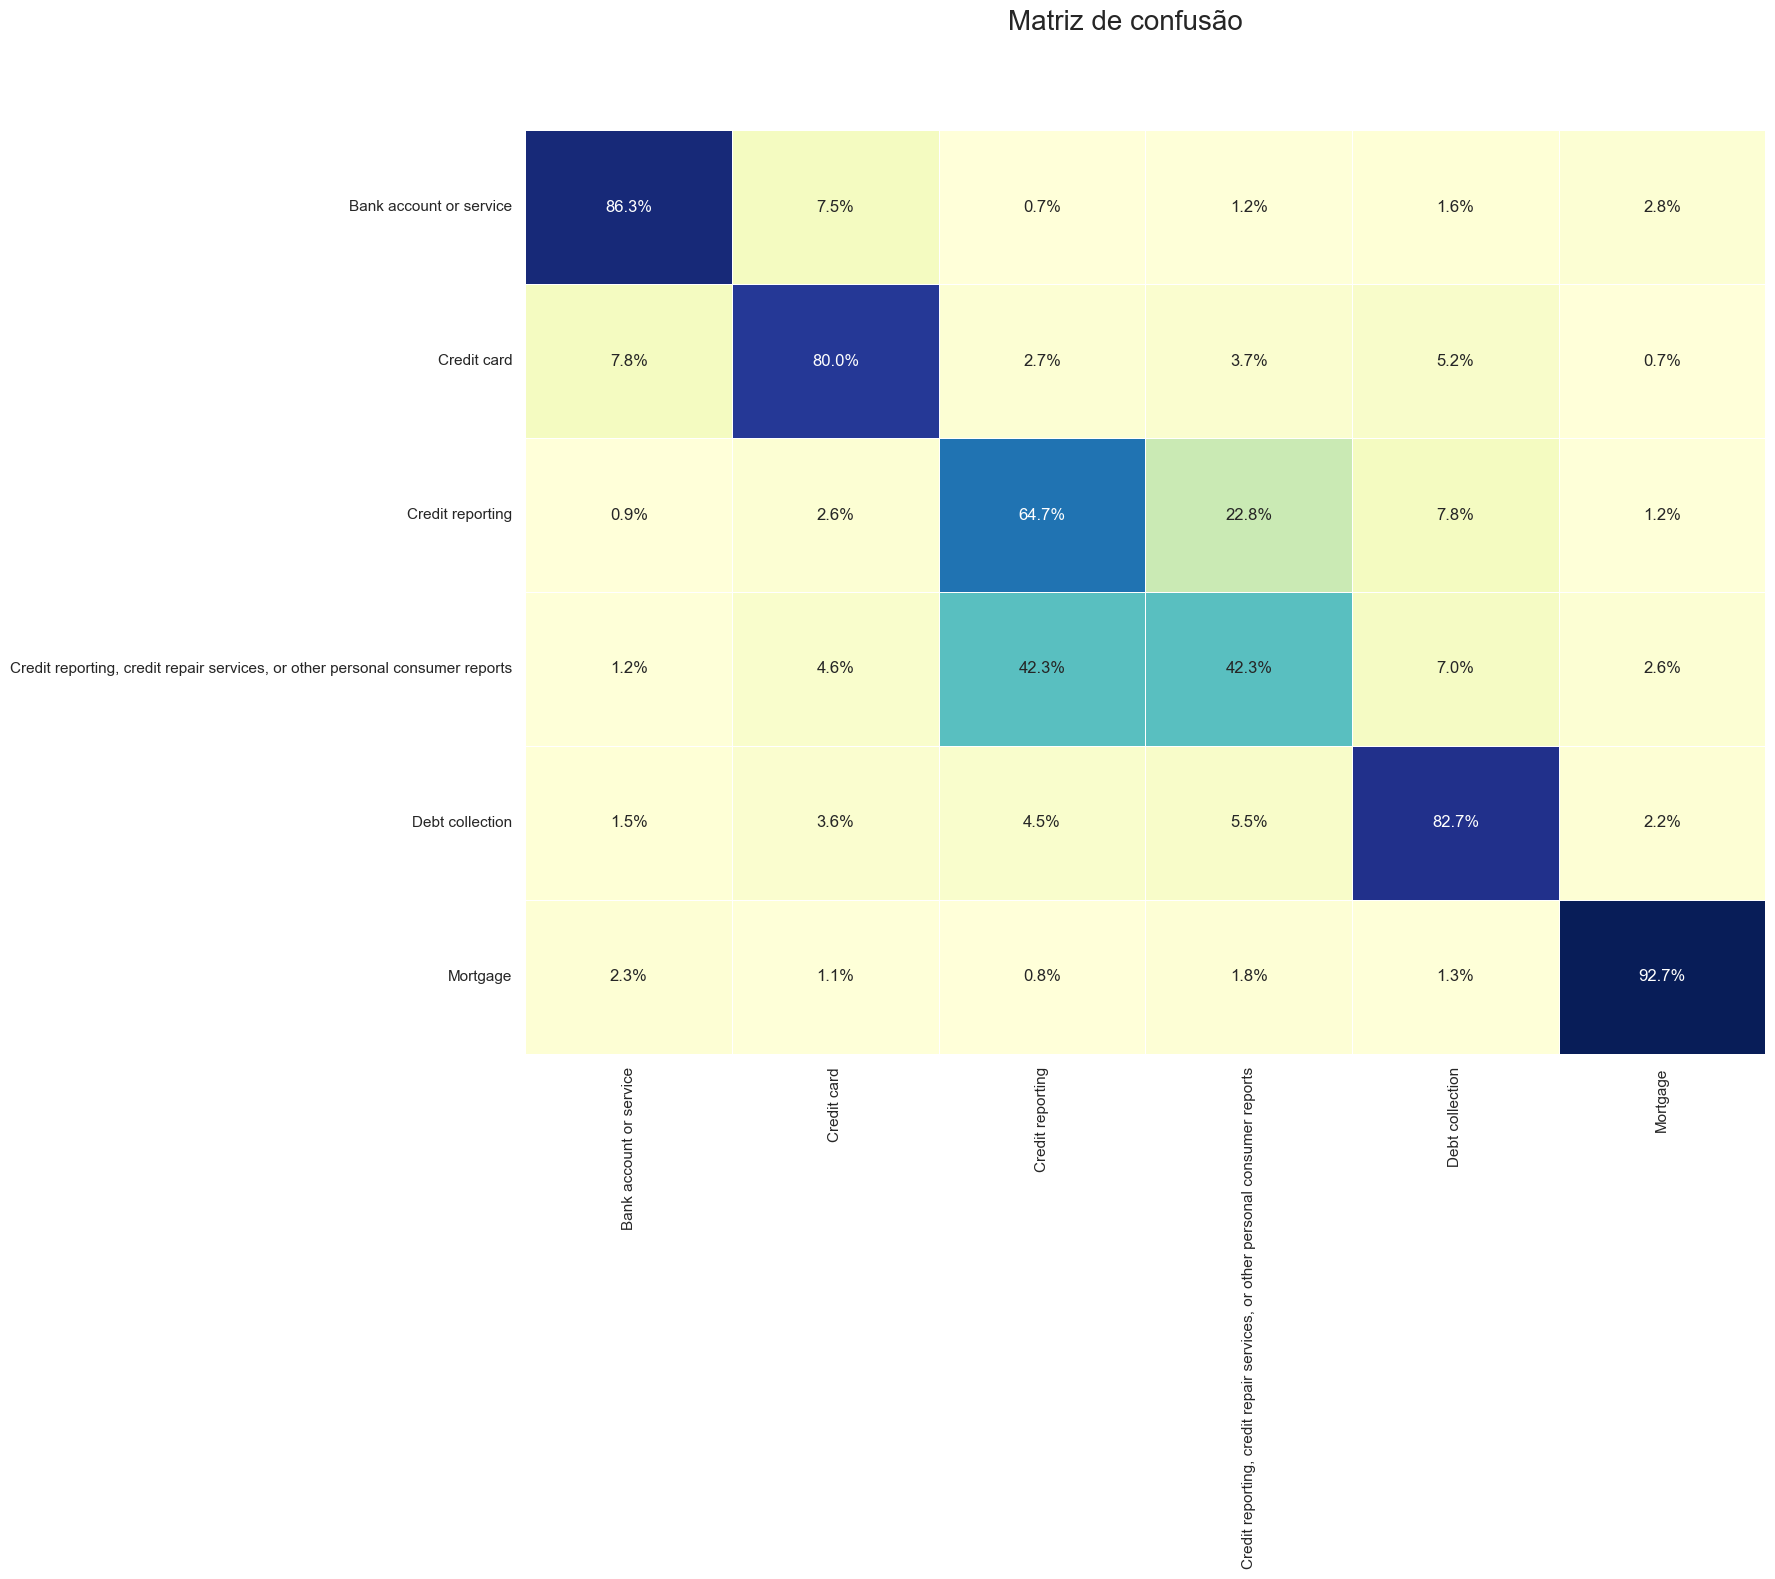

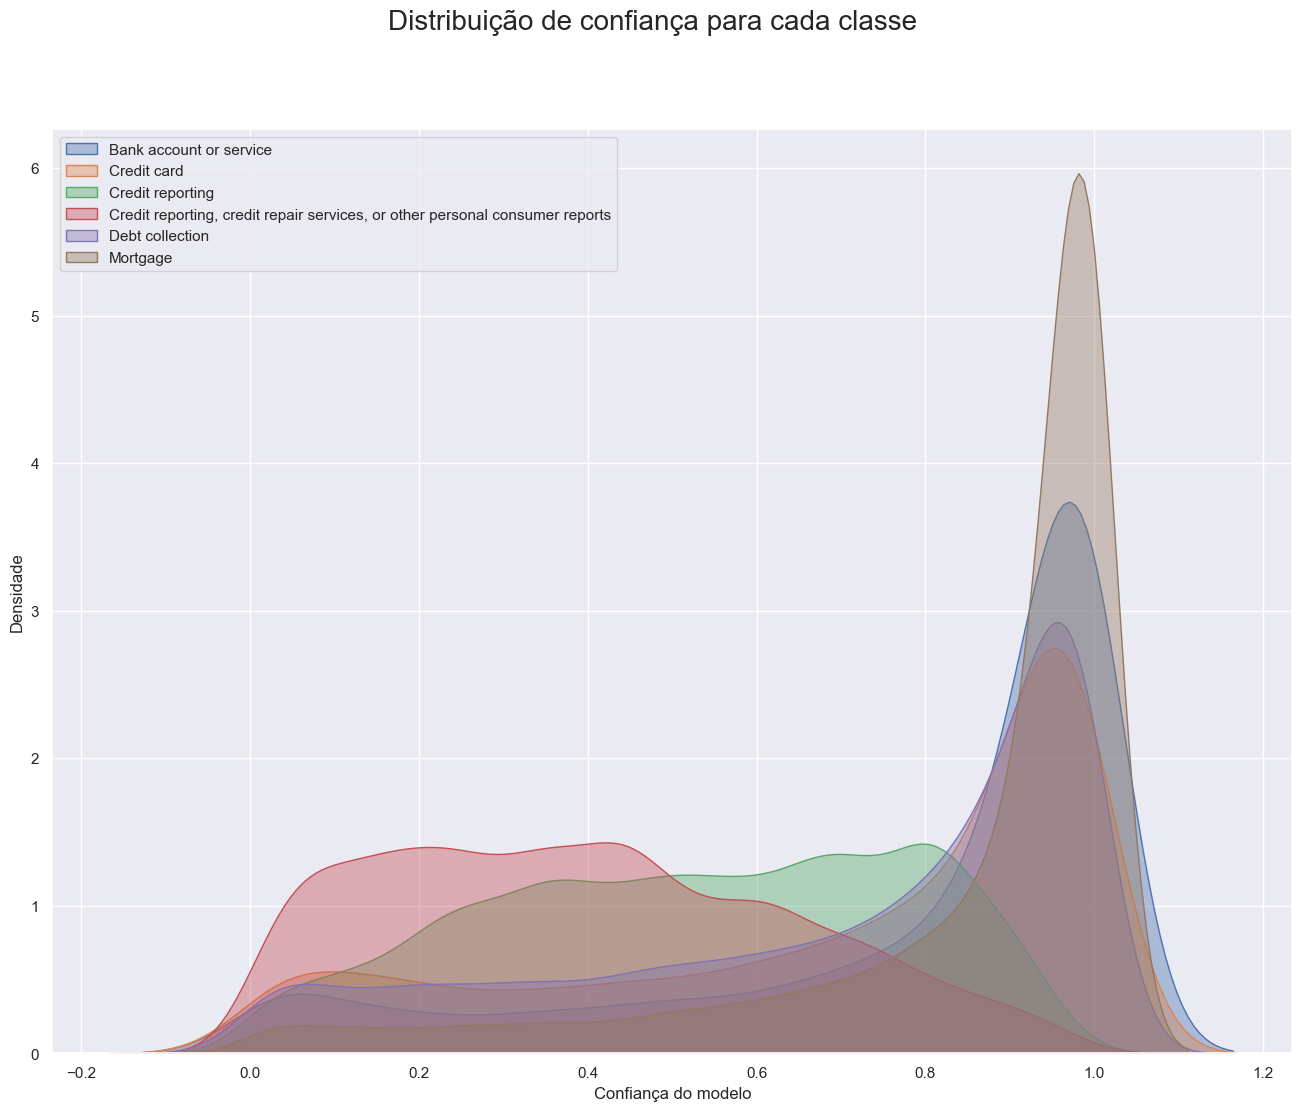

In [12]:
evaluate(ye_test, g.predict(x_test), g.predict_proba(x_test), labels=label_enc.classes_)

**Pergunta (1pt):** considerando o gráfico de distribuição de confiança para o seu modelo treinado, as amostras são classificadas com alta confiança? Há uma grande diferença de confiança entre as diferentes classes?

A confiança do modelo na maioria das classes é boa, com uma concentração expressiva entre 80% e 100%. No entanto, conseguimos perceber um espalhamento maior da distribuição para as classes "Credit reporting" e "Credit reporting, credit repair services, or other personal consumer reports". Esta diferença também é visível na matriz de confusão, onde é nítida a queda de acurácia entre as duas classes. Essa queda de performance faz sentido, já que os dois temas são ambíguos, tendo a ver com relatórios de crédito. As classes de "Bank account or service" e "Credit card" também apresentam um pouco de ambiguidade entre si, porém em nível muito menor. Este comportamento pode ser visto como um ligeiro aumento na cauda das distribuições de ambas as classes e ao observar as suas respectivas linhas na matriz de confusão (falsos positivos).

----------
----------

## Redes Neurais - Tensorflow
Iremos treinar alguns modelos de redes neurais, variando número de camadas e quantidade de neurônios em cada camada.

Vamos converter os rótulos em vetores *One Hot Encoded*:

In [13]:
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.regularizers import L2
from sklearn.utils.class_weight import compute_class_weight
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf

y_ohe_train = to_categorical(ye_train, num_classes=6)
y_ohe_test = to_categorical(ye_test, num_classes=6)

class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(y_train), y=y_train)
train_class_weights = dict(enumerate(class_weights))

**Atividade (1 pt):** defina uma arquitetura de uma rede neural capaz de classificar os diferentes produtos a partir da conversa dos clientes. Compile a sua rede com a loss `categorical_crossentropy`, optimizador `SGD` e defina as métricas relevantes para o problema.

In [14]:
model = Sequential([
    Input(shape=(features,)),
    Dense(50, activation='relu'),
    Dense(6, activation='softmax')
])

model.compile(
    optimizer=optimizers.SGD(learning_rate=1e-2, momentum=0.9),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


### Treinando a rede neural

**Atividade (1 pt):** treine o modelo definido acima sobre o conjunto, respeitando as seguintes regras:

1. Separe um subconjunto do treino para validação.
2. Utilize alguma técnica para conservar os parâmetros que melhor generalizam o problema, como `ModelCheckpoint` (salve o modelo com nome de `weights.h5`).

In [15]:
nn_X_train, nn_X_val, nn_y_train, nn_y_val = train_test_split(x_train, y_ohe_train, test_size=0.2, stratify=y_train, random_state=42)
nn_X_test, nn_y_test = x_test, y_ohe_test

In [16]:
tf.random.set_seed(42)
np.random.seed(42)
epochs = 20
batch_size = 128


checkpoint = ModelCheckpoint(
    filepath="weights.h5",
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

earlystop = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    nn_X_train, nn_y_train,
    validation_data=(nn_X_val, nn_y_val),
    epochs=epochs,
    batch_size=batch_size,
    class_weight=train_class_weights,
    callbacks=[checkpoint, earlystop],
    verbose=1
)

Epoch 1/20
705/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6582 - loss: 0.9801
Epoch 1: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7449 - loss: 0.7497 - val_accuracy: 0.7843 - val_loss: 0.5934
Epoch 2/20
699/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8136 - loss: 0.5567
Epoch 2: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8140 - loss: 0.5521 - val_accuracy: 0.7931 - val_loss: 0.5744
Epoch 3/20
692/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8357 - loss: 0.4882
Epoch 3: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8356 - loss: 0.4841 - val_accuracy: 0.7962 - val_loss: 0.5732
Epoch 4/20
698/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8535 - loss: 0.4325
Epoch 4: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8538 - loss: 0.4273 - val_accuracy: 0.7962 - val_loss: 0.5862
Epoch 5/20
694/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8695 - loss: 0.3825
Epoch 5: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8700 - loss: 0.3775 - val_accuracy: 0.7984 - val_loss: 0.6012
Epoch 6/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8817 - loss: 0.3391
Epoch 6: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8826 - loss: 0.3344 - val_accuracy: 0.8000 - val_loss: 0.6166
Epoch 7/20
689/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8928 - loss: 0.3021
Epoch 7: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8947 - loss: 0.2968 - val_accuracy: 0.8021 - val_loss: 0.6347
Epoch 8/20
693/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9040 - loss: 0.2695
Epoch 8: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9054 - loss: 0.2652 - val_accuracy: 0.8052 - val_loss: 0.6542
Epoch 9/20
694/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9132 - loss: 0.2420
Epoch 9: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9149 - loss: 0.2384 - val_accuracy: 0.8097 - val_loss: 0.6733
Epoch 10/20
692/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9220 - loss: 0.2178
Epoch 10: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9232 - loss: 0.2154 - val_accuracy: 0.8079 - val_loss: 0.7079
Epoch 11/20
689/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9282 - loss: 0.1983
Epoch 11: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9296 - loss: 0.1952 - val_accuracy: 0.8116 - val_loss: 0.7334
Epoch 12/20
687/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9350 - loss: 0.1796
Epoch 12: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9362 - loss: 0.1770 - val_accuracy: 0.8135 - val_loss: 0.7621
Epoch 13/20
694/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9407 - loss: 0.1639
Epoch 13: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9418 - loss: 0.1616 - val_accuracy: 0.8112 - val_loss: 0.8003
Epoch 14/20
688/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9471 - loss: 0.1481
Epoch 14: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9479 - loss: 0.1460 - val_accuracy: 0.8104 - val_loss: 0.8320
Epoch 15/20
686/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9524 - loss: 0.1351
Epoch 15: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9531 - loss: 0.1336 - val_accuracy: 0.8130 - val_loss: 0.8631
Epoch 16/20
693/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9578 - loss: 0.1232
Epoch 16: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9580 - loss: 0.1215 - val_accuracy: 0.8134 - val_loss: 0.8983
Epoch 17/20
694/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9621 - loss: 0.1115
Epoch 17: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9625 - loss: 0.1105 - val_accuracy: 0.8114 - val_loss: 0.9364
Epoch 18/20
687/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9657 - loss: 0.1029
Epoch 18: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9661 - loss: 0.1013 - val_accuracy: 0.8127 - val_loss: 0.9698
Epoch 19/20
692/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9686 - loss: 0.0949
Epoch 19: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9691 - loss: 0.0934 - val_accuracy: 0.8141 - val_loss: 0.9984
Epoch 20/20
713/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9722 - loss: 0.0858
Epoch 20: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9725 - loss: 0.0848 - val_accuracy: 0.8117 - val_loss: 1.0416


In [17]:
model.load_weights('weights.h5')

O método `model.fit` retorna `model.history`, e contem algumas informações interessantes a respeito do histórico de treinamento.

**Atividade (1 pt):** plote um gráfico de linhas exibindo a evolução dos valores da função *loss* sobre o conjunto de treino e validação. A partir de qual `epoch` a rede começou a super-especializar?

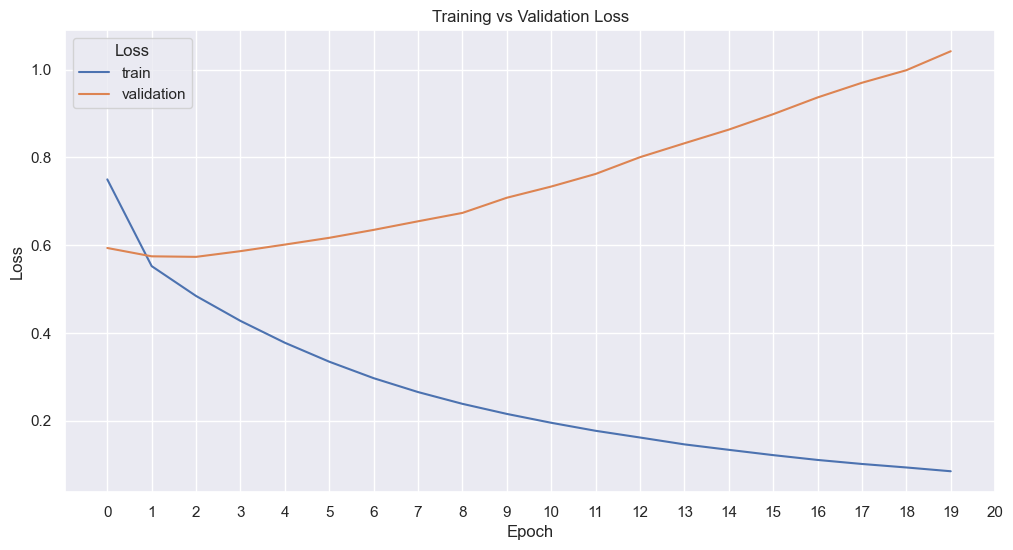

In [18]:
df = pd.DataFrame({
    'epoch': history.epoch,
    'train': history.history['loss'],
    'validation': history.history['val_loss']
})

# Melt to long format
df_melted = df.melt(id_vars='epoch', value_vars=['train', 'validation'],
                    var_name='Loss', value_name='loss')

# Plot
sns.lineplot(data=df_melted, x='epoch', y='loss', hue='Loss')
plt.title('Training vs Validation Loss')
plt.xticks(range(0, epochs+1, 1))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

A progressão da loss mostrou uma degradação rápida no gráfico, indicando que o modelo ainda não está conseguindo capturar bem a complexidade dos dados. A partir da época 3, o erro de validação já começou a subir de forma consistente, indicando um overfit do modelo, já que o erro de treinamento manteve uma queda constante.

### Avaliando o modelo treinado

**Atividade (1 pt):** teste o modelo treinado utilizando o subconjunto de teste. Reporte a acurácia para cada classe e a matriz de confusão percentual (usando a função `evaluate` definida anteriormente).

In [19]:
y_pred = model.predict(nn_X_test)

1543/1543 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


Accuracy: 0.717
Accuracy (balanced): 0.700


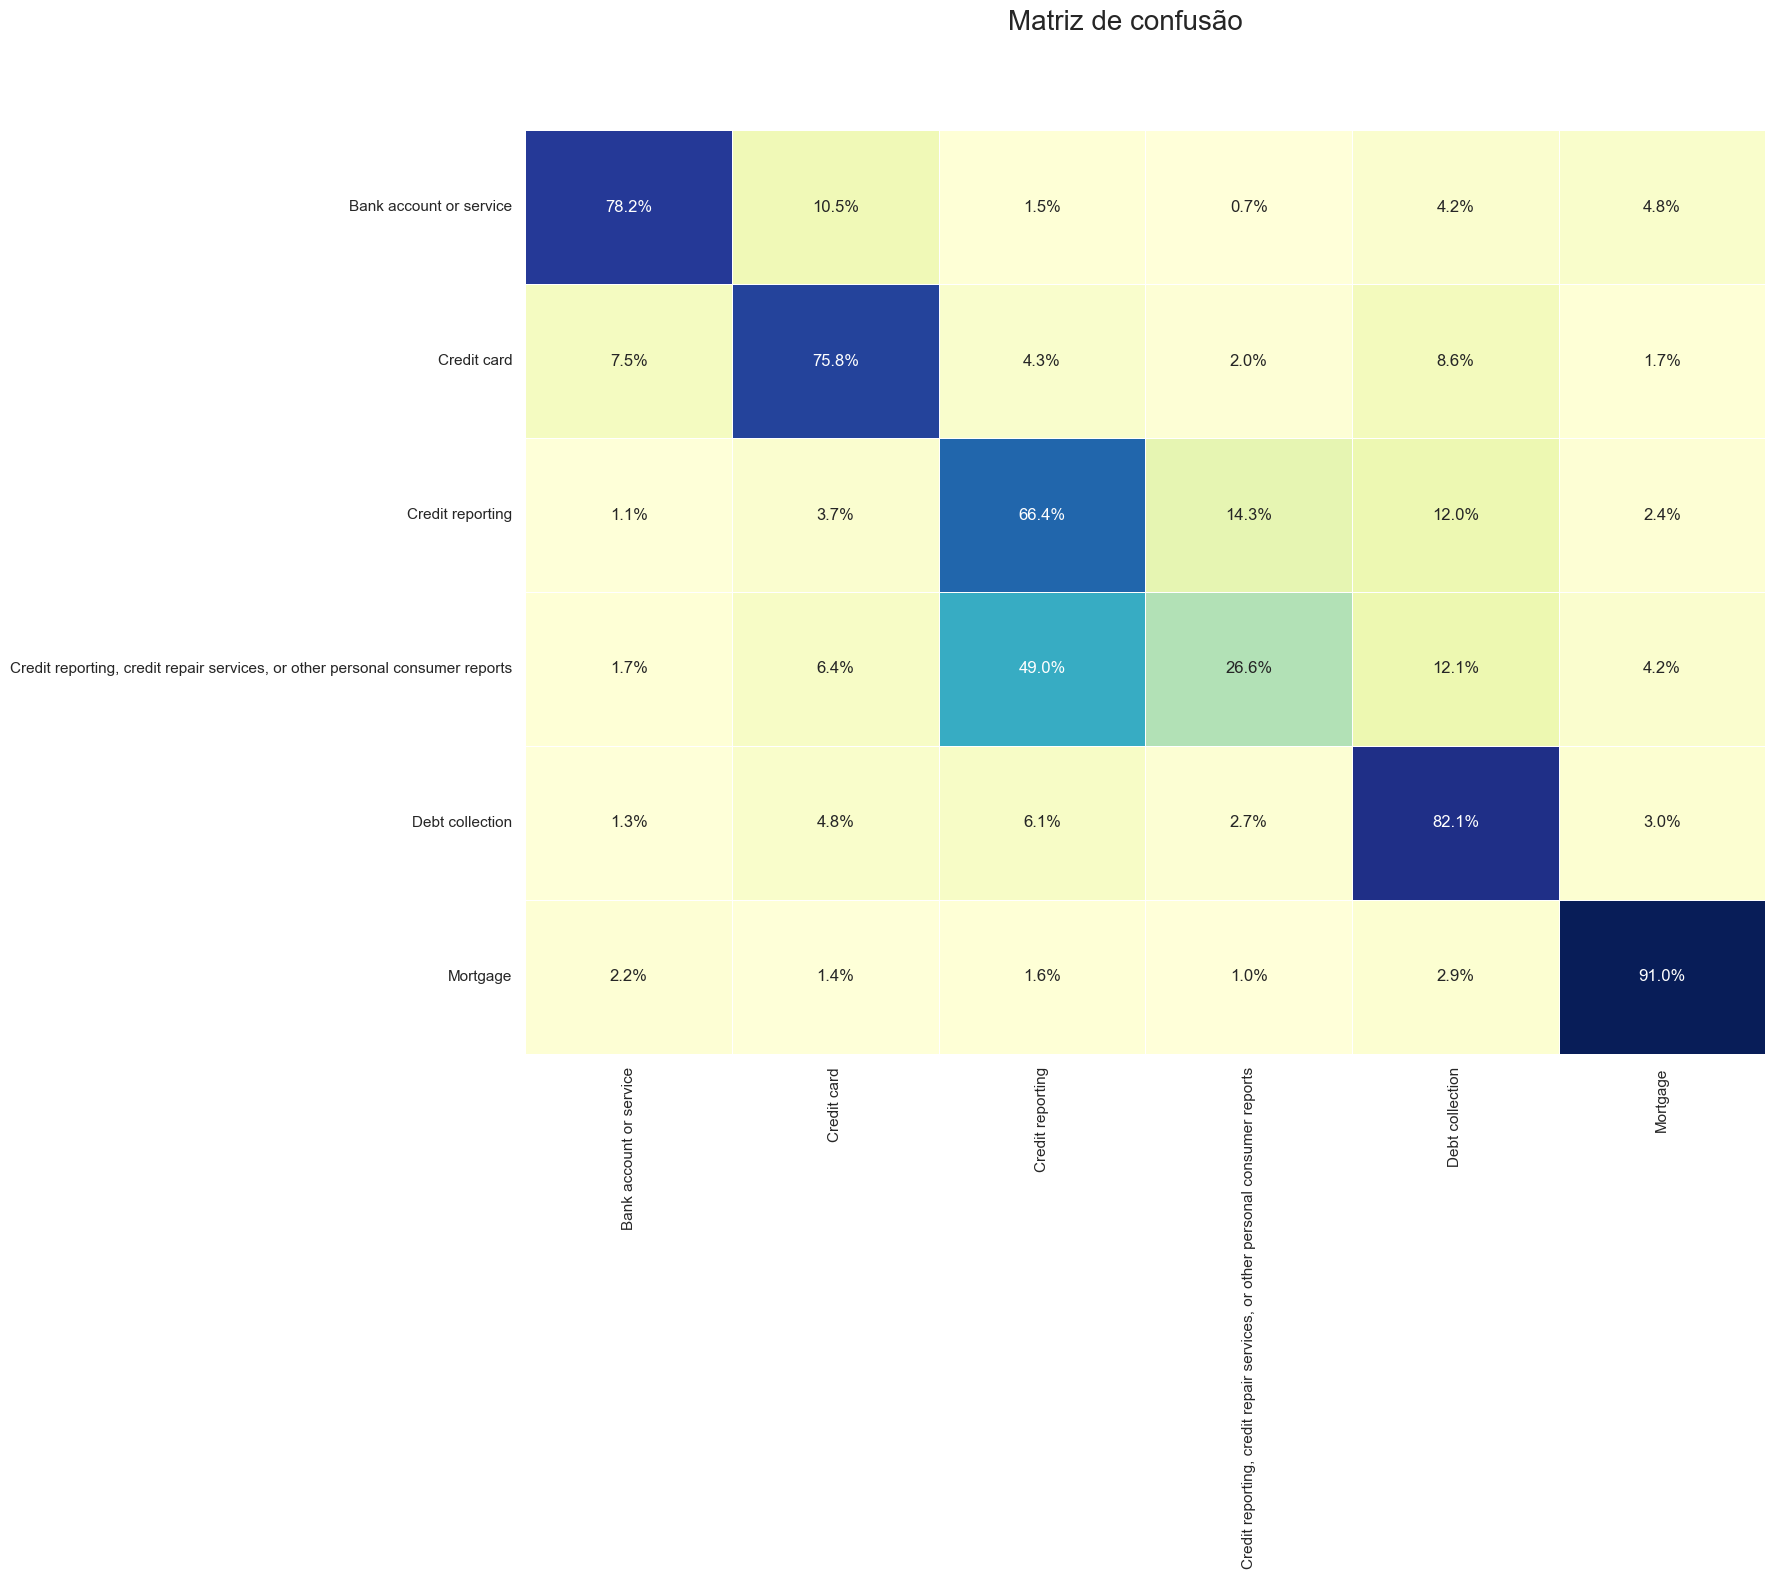

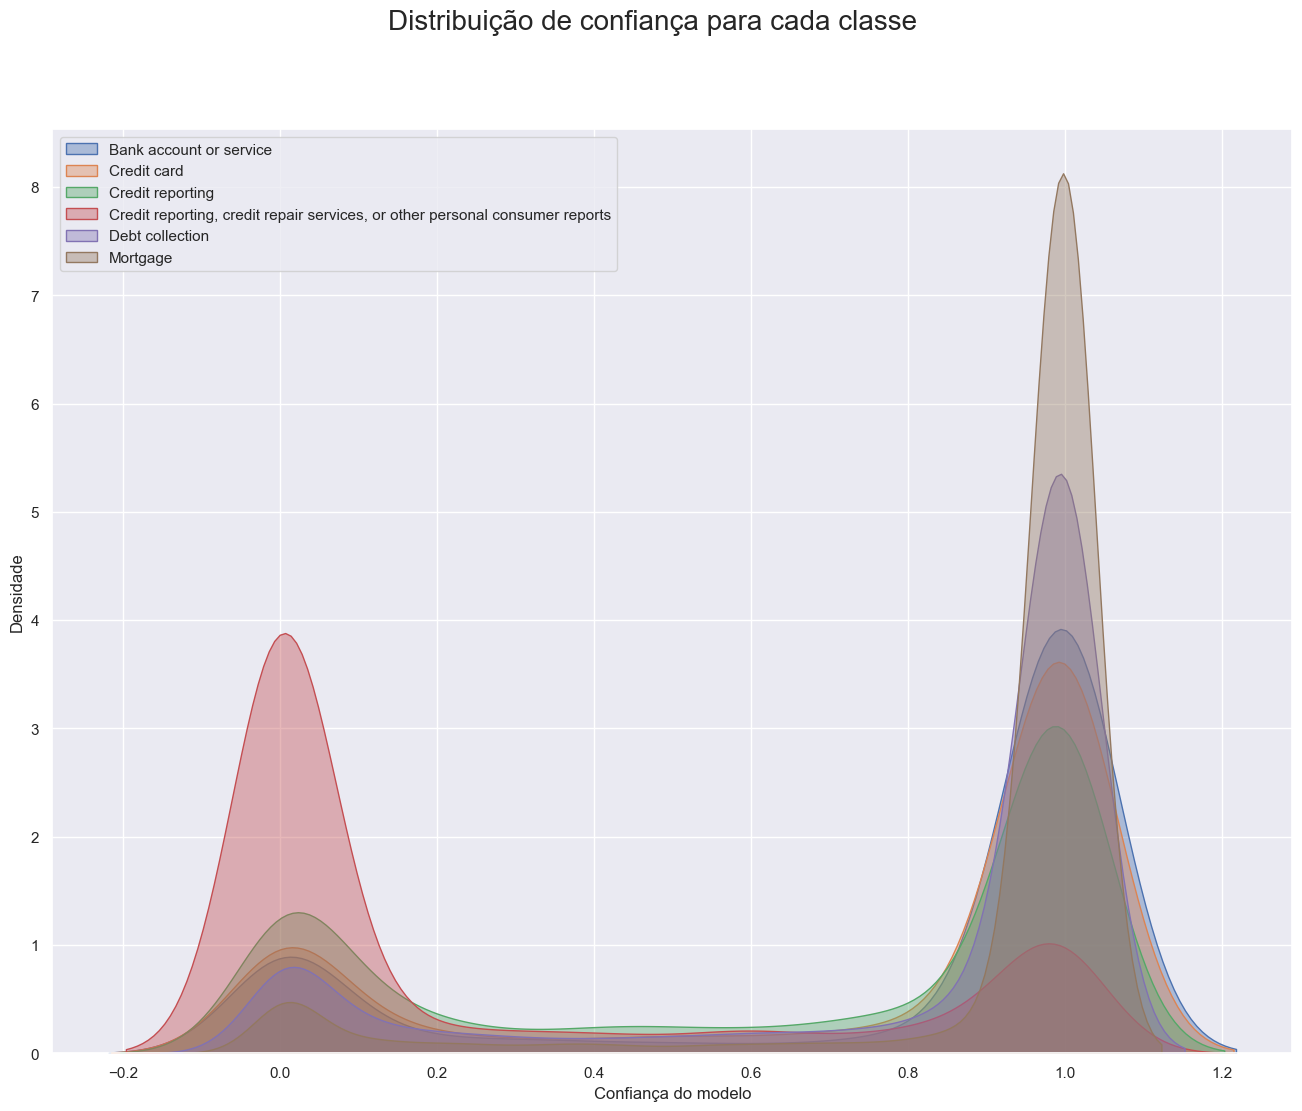

In [20]:
## para poder usar a função, precisei utilizar o dataset ye_test, sem one hot encoding
evaluate(ye_test, np.argmax(y_pred, axis=1), y_pred, labels=label_enc.classes_)

--------

Repita agora a definição, treinamento e avaliação de uma rede neural mais complexa, aumentando o número de camadas ou a quantidade de neurônios nas camadas da rede anterior:

**Atividade (1 pt):** defina uma rede neural mais complexa e a compile com as mesmas configurações da rede anterior.

In [21]:
model2 = Sequential([
    Input(shape=(features,)),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(6, activation='softmax')
])

model2.compile(
    optimizer=optimizers.SGD(learning_rate=1e-2, momentum=0.9),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

**Atividade (1 pt):** treine a nova rede.

In [22]:
tf.random.set_seed(42)
np.random.seed(42)
epochs = 20
batch_size = 128

earlystop2 = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=10,
    restore_best_weights=True
)


checkpoint2 = ModelCheckpoint(
    filepath="weights2.h5",
    monitor='val_accuracy',
    mode='max',
    verbose=1
)


history2 = model.fit(
    nn_X_train, nn_y_train,
    validation_data=(nn_X_val, nn_y_val),
    epochs=epochs,
    batch_size=batch_size,
    class_weight=train_class_weights,
    callbacks=[earlystop2, checkpoint2],
)

Epoch 1/20
693/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9747 - loss: 0.0797
Epoch 1: saving model to weights2.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9752 - loss: 0.0788 - val_accuracy: 0.8108 - val_loss: 1.0751
Epoch 2/20
713/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9769 - loss: 0.0738
Epoch 2: saving model to weights2.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9780 - loss: 0.0725 - val_accuracy: 0.8120 - val_loss: 1.1040
Epoch 3/20
703/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9789 - loss: 0.0692
Epoch 3: saving model to weights2.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9798 - loss: 0.0672 - val_accuracy: 0.8125 - val_loss: 1.1377
Epoch 4/20
707/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9810 - loss: 0.0632
Epoch 4: saving model to weights2.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9819 - loss: 0.0619 - val_accuracy: 0.8139 - val_loss: 1.1658
Epoch 5/20
706/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9835 - loss: 0.0582
Epoch 5: saving model to weights2.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9842 - loss: 0.0567 - val_accuracy: 0.8129 - val_loss: 1.1979
Epoch 6/20
708/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9851 - loss: 0.0534
Epoch 6: saving model to weights2.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9857 - loss: 0.0519 - val_accuracy: 0.8125 - val_loss: 1.2267
Epoch 7/20
713/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9871 - loss: 0.0485
Epoch 7: saving model to weights2.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9876 - loss: 0.0479 - val_accuracy: 0.8146 - val_loss: 1.2568
Epoch 8/20
713/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9882 - loss: 0.0459
Epoch 8: saving model to weights2.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9890 - loss: 0.0440 - val_accuracy: 0.8133 - val_loss: 1.2853
Epoch 9/20
707/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9892 - loss: 0.0421
Epoch 9: saving model to weights2.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9897 - loss: 0.0409 - val_accuracy: 0.8142 - val_loss: 1.3163
Epoch 10/20
706/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9905 - loss: 0.0404
Epoch 10: saving model to weights2.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9907 - loss: 0.0396 - val_accuracy: 0.8126 - val_loss: 1.3464
Epoch 11/20
716/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9908 - loss: 0.0381
Epoch 11: saving model to weights2.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9915 - loss: 0.0371 - val_accuracy: 0.8141 - val_loss: 1.3679
Epoch 12/20
705/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9919 - loss: 0.0358
Epoch 12: saving model to weights2.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9921 - loss: 0.0347 - val_accuracy: 0.8135 - val_loss: 1.3954
Epoch 13/20
712/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9924 - loss: 0.0347
Epoch 13: saving model to weights2.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9927 - loss: 0.0339 - val_accuracy: 0.8139 - val_loss: 1.4171
Epoch 14/20
707/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9928 - loss: 0.0326
Epoch 14: saving model to weights2.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9931 - loss: 0.0321 - val_accuracy: 0.8131 - val_loss: 1.4420
Epoch 15/20
711/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9936 - loss: 0.0306
Epoch 15: saving model to weights2.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9939 - loss: 0.0296 - val_accuracy: 0.8138 - val_loss: 1.4608
Epoch 16/20
708/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9937 - loss: 0.0295
Epoch 16: saving model to weights2.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9940 - loss: 0.0284 - val_accuracy: 0.8138 - val_loss: 1.4846
Epoch 17/20
686/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9940 - loss: 0.0283
Epoch 17: saving model to weights2.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9944 - loss: 0.0275 - val_accuracy: 0.8135 - val_loss: 1.5058


**Atividade (1 pt):** adicione dropout ou regularização L1/L2 e treine o novo modelo. Se for, preciso, faça uma busca pelos hipeparâmetros da regularização/dropout.

In [23]:
tf.random.set_seed(42)
np.random.seed(42)

model3 = Sequential([
    Input(shape=(features,)),
    Dense(16, activation='relu'),
    Dropout(0.5),
    Dense(16, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')
])

model3.compile(
    optimizer=optimizers.SGD(learning_rate=1e-2, momentum=0.9),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

epochs = 20
batch_size = 128

earlystop3 = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=10,
    restore_best_weights=True
)

checkpoint3 = ModelCheckpoint(
    filepath="weights3.h5",
    monitor='val_accuracy',
    mode='max',
    verbose=1
)


history3 = model.fit(
    nn_X_train, nn_y_train,
    validation_data=(nn_X_val, nn_y_val),
    epochs=epochs,
    batch_size=batch_size,
    class_weight=train_class_weights,
    callbacks=[earlystop3, checkpoint3],
)

Epoch 1/20
706/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9881 - loss: 0.0459
Epoch 1: saving model to weights3.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9890 - loss: 0.0439 - val_accuracy: 0.8134 - val_loss: 1.2849
Epoch 2/20
716/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9895 - loss: 0.0418
Epoch 2: saving model to weights3.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9900 - loss: 0.0408 - val_accuracy: 0.8137 - val_loss: 1.3154
Epoch 3/20
713/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9904 - loss: 0.0397
Epoch 3: saving model to weights3.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9908 - loss: 0.0384 - val_accuracy: 0.8139 - val_loss: 1.3428
Epoch 4/20
711/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9911 - loss: 0.0374
Epoch 4: saving model to weights3.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9915 - loss: 0.0372 - val_accuracy: 0.8134 - val_loss: 1.3676
Epoch 5/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9919 - loss: 0.0361
Epoch 5: saving model to weights3.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9923 - loss: 0.0348 - val_accuracy: 0.8136 - val_loss: 1.3943
Epoch 6/20
715/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9925 - loss: 0.0342
Epoch 6: saving model to weights3.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9928 - loss: 0.0331 - val_accuracy: 0.8133 - val_loss: 1.4182
Epoch 7/20
716/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9923 - loss: 0.0344
Epoch 7: saving model to weights3.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9927 - loss: 0.0335 - val_accuracy: 0.8144 - val_loss: 1.4402
Epoch 8/20
716/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9929 - loss: 0.0326
Epoch 8: saving model to weights3.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9934 - loss: 0.0315 - val_accuracy: 0.8138 - val_loss: 1.4626
Epoch 9/20
716/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9935 - loss: 0.0305
Epoch 9: saving model to weights3.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9938 - loss: 0.0297 - val_accuracy: 0.8128 - val_loss: 1.4908
Epoch 10/20
719/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9939 - loss: 0.0290
Epoch 10: saving model to weights3.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9944 - loss: 0.0281 - val_accuracy: 0.8136 - val_loss: 1.5062
Epoch 11/20
691/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9943 - loss: 0.0279
Epoch 11: saving model to weights3.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9947 - loss: 0.0269 - val_accuracy: 0.8139 - val_loss: 1.5263
Epoch 12/20
689/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9949 - loss: 0.0256
Epoch 12: saving model to weights3.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9950 - loss: 0.0255 - val_accuracy: 0.8128 - val_loss: 1.5497
Epoch 13/20
694/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9945 - loss: 0.0274
Epoch 13: saving model to weights3.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9951 - loss: 0.0256 - val_accuracy: 0.8137 - val_loss: 1.5630
Epoch 14/20
714/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9952 - loss: 0.0242
Epoch 14: saving model to weights3.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9954 - loss: 0.0238 - val_accuracy: 0.8130 - val_loss: 1.5808
Epoch 15/20
714/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9955 - loss: 0.0240
Epoch 15: saving model to weights3.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9955 - loss: 0.0238 - val_accuracy: 0.8133 - val_loss: 1.5982
Epoch 16/20
688/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9952 - loss: 0.0247
Epoch 16: saving model to weights3.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9954 - loss: 0.0242 - val_accuracy: 0.8127 - val_loss: 1.6179
Epoch 17/20
692/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9951 - loss: 0.0262
Epoch 17: saving model to weights3.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9945 - loss: 0.0275 - val_accuracy: 0.8114 - val_loss: 1.6483


**Atividade (1 pt):** avalie os modelos treinados e compare com os resultados anteriores.

In [24]:
y_pred2 = model2.predict(nn_X_test)
y_pred3 = model3.predict(nn_X_test)

1543/1543 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1543/1543 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


Curiosamente, o primeiro modelo testado, muito mais simples, se mostrou muito superior a todos os outros, mesmo após algumas tentativas de regularização e mudanças em outros hiperparâmetros. O primeiro modelo de rede neural, com apenas uma hidden layer de 50 unidades, conseguiu atingir uma acurácia de 72%, enquanto os outros foram muito piores. Tentamos investigar motivos, mas em todos os treinamentos dos modelos seguintes, o comportamento do loss sempre foi ascendente na validação, mostrando grande dificuldade de aprendizado nos modelos.

In [ ]:
print(metrics.classification_report(ye_test, np.argmax(y_pred, axis=1), target_names=label_enc.classes_))

                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.76      0.78      0.77      4058
                                                                 Credit card       0.65      0.76      0.70      4902
                                                            Credit reporting       0.53      0.66      0.59      8604
Credit reporting, credit repair services, or other personal consumer reports       0.52      0.27      0.35      7620
                                                             Debt collection       0.80      0.82      0.81     13884
                                                                    Mortgage       0.88      0.91      0.90     10279

                                                                    accuracy                           0.72     49347
                                                      

In [26]:

print(metrics.classification_report(ye_test, np.argmax(y_pred2, axis=1), target_names=label_enc.classes_))

                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.07      0.03      0.04      4058
                                                                 Credit card       0.10      0.03      0.05      4902
                                                            Credit reporting       0.17      0.42      0.24      8604
Credit reporting, credit repair services, or other personal consumer reports       0.17      0.51      0.26      7620
                                                             Debt collection       0.25      0.01      0.02     13884
                                                                    Mortgage       0.27      0.05      0.09     10279

                                                                    accuracy                           0.17     49347
                                                      

In [27]:
print(metrics.classification_report(ye_test, np.argmax(y_pred3, axis=1), target_names=label_enc.classes_))

                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.13      0.00      0.00      4058
                                                                 Credit card       0.08      0.06      0.07      4902
                                                            Credit reporting       0.16      0.36      0.22      8604
Credit reporting, credit repair services, or other personal consumer reports       0.17      0.42      0.24      7620
                                                             Debt collection       0.46      0.01      0.02     13884
                                                                    Mortgage       0.16      0.11      0.13     10279

                                                                    accuracy                           0.16     49347
                                                      